In [1]:
import pandas as pd
import selfies as sf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from rxitect.chem.utils import batch_calc_fp, calc_fp, calc_ecfp, calc_physchem
from rdkit import Chem
from rdkit.Chem import PandasTools, AllChem

In [2]:
def safe_smiles_to_selfies(smiles):
    try:
        return sf.encoder(smiles)
    except sf.EncoderError:
        pass

In [3]:
df = pd.read_parquet("../data/processed/CHEMBL240_dataset_xuhan.pq")
# df['selfies'] = [safe_smiles_to_selfies(smi) for smi in df['smiles']]

In [4]:
df = df.dropna(subset=['pchembl value'])

In [5]:
PandasTools.AddMoleculeColumnToFrame(df, 'smiles', 'mol')

In [6]:
df['fingerprint'] = df.mol.apply(calc_fp)

In [7]:
timeidx_test = (df['document year'] > 2015).values
timeidx_train = (df['document year'] <= 2015).values

In [8]:
X = np.stack(df.fingerprint.values)

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
y = df['pchembl value'].values.reshape((-1, 1))

In [11]:
NORMAL_SPLIT = True

if NORMAL_SPLIT:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)
else:
    X_train, X_test, y_train, y_test = X[timeidx_train], X[timeidx_test], y[timeidx_train], y[timeidx_test]
    
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
# y_val = scaler.transform(y_val)

In [12]:
from sklearn.feature_selection import VarianceThreshold

feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
# X_val = feature_select.transform(X_val)
X_test = feature_select.transform(X_test)
X_train.shape

(9951, 263)

In [13]:
import torch
device = "cuda"

/home/julius/miniconda3/envs/rxt-dev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
X_train = torch.tensor(X_train, device=device, dtype=torch.float32)
X_test = torch.tensor(X_test, device=device, dtype=torch.float32)
# X_val = torch.tensor(X_val, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train, device=device, dtype=torch.float32)
y_test = torch.tensor(y_test, device=device, dtype=torch.float32)
# y_val = torch.tensor(y_val, device=device, dtype=torch.float32)


In [15]:
X_train.shape

torch.Size([9951, 263])

In [16]:
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train)
# val_dataset = TensorDataset(X_val, y_val)

In [17]:
train_loader = DataLoader(dataset=train_dataset, batch_size=256, shuffle=True)
# val_loader = DataLoader(dataset=val_dataset, batch_size=256, shuffle=False)

In [18]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected =&amp;gt; Layer Norm =&amp;gt; LeakyReLU =&amp;gt; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out

In [49]:
input_size = X_train.size()[-1]
hidden_size = 1024
dropout_rate = 0.8
out_size = 1
learning_rate = 0.001
model = Net(input_size, hidden_size, dropout_rate, out_size)

In [50]:
model.cuda()

Net(
  (fc1): Linear(in_features=263, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [51]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [52]:
scaled_px = scaler.transform(np.array([3.99]).reshape(1,-1)).item()

In [53]:
# 5CV ATTEMPT, it ain't looking good...

from sklearn.model_selection import KFold
model = Net(input_size, hidden_size, dropout_rate, out_size)
model.cuda()
epochs = 200
# model.train()
folds = KFold(5).split(X_train)
indep_set = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
indep_loader = DataLoader(indep_set, batch_size=256, shuffle=False)
cvs = np.zeros(y_train.shape)
inds = np.zeros(y_test.shape)
for i, (trained, valided) in enumerate(folds):
    model.train()
    train_set = TensorDataset(torch.tensor(X_train[trained]), torch.tensor(y_train[trained]))
    train_loader = DataLoader(train_set, batch_size=256, shuffle=False)
    valid_set = TensorDataset(torch.tensor(X_train[valided]), torch.tensor(y_train[valided]))
    valid_loader = DataLoader(valid_set, batch_size=256, shuffle=False)
    # net = NET(X.shape[1], y.shape[1], is_reg=reg)
    # net.fit(train_loader, valid_loader, out='%s_%d' % (out, i), epochs=N_EPOCH, lr=LR)
    for e in range(epochs):
        running_loss = 0
        for fp, label in train_loader:
            optimizer.zero_grad()

            output = model(fp)
            weight = torch.zeros(label.size()).to(device)
            down_idx = (label == scaled_px)#.reshape(-1)
            up_idx = (label != scaled_px)#.reshape(-1)
            weight[down_idx] = 0.05
            weight[up_idx] = 1
            # loss function calculation based on predicted tensor and label tensor
            loss = criterion(output * weight, label * weight)  # Weighted loss updates to discount negative examples
            # loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        if e%25 == 0:
            print("Fold: %3i Epoch: %3i Training loss: %0.2F"%(i, e,(running_loss/len(train_loader))))
    model.eval()
    cvs[valided] = model(torch.tensor(X_train[valided])).cpu().detach().numpy().reshape(-1)
    inds += model(torch.tensor(X_test)).cpu().detach().numpy().reshape(-1)
# return cvs, inds / 5

/tmp/ipykernel_37629/3957737693.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  indep_set = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
/tmp/ipykernel_37629/3957737693.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_set = TensorDataset(torch.tensor(X_train[trained]), torch.tensor(y_train[trained]))
/tmp/ipykernel_37629/3957737693.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  valid_set = TensorDataset(torch.tensor(X_train[valided]), torch.tensor(y_train[valided]))
/home/julius/miniconda3/envs/rxt-dev/lib

Fold:   0 Epoch:   0 Training loss: 1.66
Fold:   0 Epoch:  25 Training loss: 1.65
Fold:   0 Epoch:  50 Training loss: 1.64
Fold:   0 Epoch:  75 Training loss: 1.65
Fold:   0 Epoch: 100 Training loss: 1.63
Fold:   0 Epoch: 125 Training loss: 1.62
Fold:   0 Epoch: 150 Training loss: 1.63
Fold:   0 Epoch: 175 Training loss: 1.63


/tmp/ipykernel_37629/3957737693.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cvs[valided] = model(torch.tensor(X_train[valided])).cpu().detach().numpy().reshape(-1)
/tmp/ipykernel_37629/3957737693.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inds += model(torch.tensor(X_test)).cpu().detach().numpy().reshape(-1)


Fold:   1 Epoch:   0 Training loss: 1.64
Fold:   1 Epoch:  25 Training loss: 1.61
Fold:   1 Epoch:  50 Training loss: 1.65
Fold:   1 Epoch:  75 Training loss: 1.64
Fold:   1 Epoch: 100 Training loss: 1.61
Fold:   1 Epoch: 125 Training loss: 1.61
Fold:   1 Epoch: 150 Training loss: 1.63
Fold:   1 Epoch: 175 Training loss: 1.64
Fold:   2 Epoch:   0 Training loss: 1.66
Fold:   2 Epoch:  25 Training loss: 1.65
Fold:   2 Epoch:  50 Training loss: 1.66
Fold:   2 Epoch:  75 Training loss: 1.65
Fold:   2 Epoch: 100 Training loss: 1.66
Fold:   2 Epoch: 125 Training loss: 1.63
Fold:   2 Epoch: 150 Training loss: 1.65
Fold:   2 Epoch: 175 Training loss: 1.64
Fold:   3 Epoch:   0 Training loss: 1.62
Fold:   3 Epoch:  25 Training loss: 1.64
Fold:   3 Epoch:  50 Training loss: 1.65
Fold:   3 Epoch:  75 Training loss: 1.62
Fold:   3 Epoch: 100 Training loss: 1.61
Fold:   3 Epoch: 125 Training loss: 1.64
Fold:   3 Epoch: 150 Training loss: 1.66
Fold:   3 Epoch: 175 Training loss: 1.62


/home/julius/miniconda3/envs/rxt-dev/lib/python3.10/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([172])) that is different to the input size (torch.Size([172, 172])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Fold:   4 Epoch:   0 Training loss: 1.63
Fold:   4 Epoch:  25 Training loss: 1.64
Fold:   4 Epoch:  50 Training loss: 1.66
Fold:   4 Epoch:  75 Training loss: 1.62
Fold:   4 Epoch: 100 Training loss: 1.65
Fold:   4 Epoch: 125 Training loss: 1.65
Fold:   4 Epoch: 150 Training loss: 1.67
Fold:   4 Epoch: 175 Training loss: 1.67


In [57]:
# Worst R2 of all time :<
r2_score(y_test.cpu(), (inds / 5))

-0.035532236547141105

In [23]:
model.train()
epochs = 500
for e in range(epochs):
    running_loss = 0
    for fp, label in train_loader:
        optimizer.zero_grad()
        
        output = model(fp)
        weight = torch.zeros(label.size()).to(device)
        down_idx = (label == scaled_px)#.reshape(-1)
        up_idx = (label != scaled_px)#.reshape(-1)
        weight[down_idx] = 0.05
        weight[up_idx] = 1
        # loss function calculation based on predicted tensor and label tensor
        loss = criterion(output * weight, label * weight)  # Weighted loss updates to discount negative examples
        # loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if e%10 == 0:
        print("Epoch: %3i Training loss: %0.2F"%(e,(running_loss/len(train_loader))))
        # model.eval()
        # with torch.no_grad():
        #     val_loss = torch.mean(( y_val - model(X_val) )**2).item()
        #     print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), val_loss))
        # model.train()

Epoch:   0 Training loss: 1.15
Epoch:  10 Training loss: 0.68
Epoch:  20 Training loss: 0.67
Epoch:  30 Training loss: 0.66
Epoch:  40 Training loss: 0.62
Epoch:  50 Training loss: 0.59
Epoch:  60 Training loss: 0.56
Epoch:  70 Training loss: 0.48
Epoch:  80 Training loss: 0.44
Epoch:  90 Training loss: 0.43
Epoch: 100 Training loss: 0.41
Epoch: 110 Training loss: 0.40
Epoch: 120 Training loss: 0.38
Epoch: 130 Training loss: 0.38
Epoch: 140 Training loss: 0.37
Epoch: 150 Training loss: 0.36
Epoch: 160 Training loss: 0.35
Epoch: 170 Training loss: 0.35
Epoch: 180 Training loss: 0.34
Epoch: 190 Training loss: 0.32
Epoch: 200 Training loss: 0.33
Epoch: 210 Training loss: 0.32
Epoch: 220 Training loss: 0.32
Epoch: 230 Training loss: 0.32
Epoch: 240 Training loss: 0.31
Epoch: 250 Training loss: 0.30
Epoch: 260 Training loss: 0.30
Epoch: 270 Training loss: 0.29
Epoch: 280 Training loss: 0.29
Epoch: 290 Training loss: 0.29
Epoch: 300 Training loss: 0.28
Epoch: 310 Training loss: 0.28
Epoch: 3

In [24]:
# print(f"samples before clean: {y_train.shape}")
to_keep = (y_train != scaled_px)
y_train = y_train[to_keep]
X_train = X_train[to_keep.reshape(-1)]
# print(f"samples afteR clean: {y_train.shape}")

In [25]:
# X_train[to_keep].shape
to_keep = (y_test != scaled_px)
y_test = y_test[to_keep]
X_test = X_test[to_keep.reshape(-1)]

In [26]:
model.eval()
y_pred_train = model(X_train)
# y_pred_val = model(X_val)
y_pred_test = model(X_test)

In [27]:
torch.mean(( y_train - y_pred_train )**2).item()

1.3820466995239258

In [28]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

In [29]:
y_test.shape

torch.Size([2035])

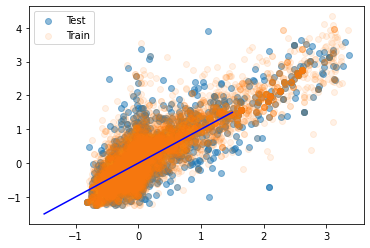

In [30]:
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

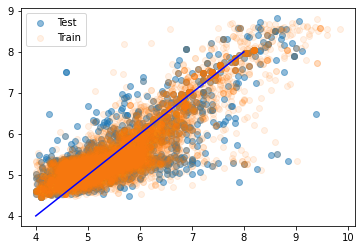

In [31]:
plt.scatter(y=scaler.inverse_transform(y_pred_test.cpu().detach().numpy()).reshape(-1), x=scaler.inverse_transform(y_test.cpu().detach().numpy().reshape(-1, 1)), alpha=0.5, label="Test")
plt.scatter(y=scaler.inverse_transform(y_pred_train.cpu().detach().numpy()).reshape(-1), x=scaler.inverse_transform(y_train.cpu().detach().numpy().reshape(-1, 1)), alpha=0.1, label="Train")
plt.legend()
plt.plot()
plt.plot([4, 8], [4,8], c="b")

In [32]:
def predict_smiles(smiles):
    fp =calc_fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=device).float()
    prediction = model(fp_tensor)
    #return prediction.cpu().detach().numpy()
    pchembl_value = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return pchembl_value[0][0]
predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')

5.148722

In [33]:
from sklearn.metrics import r2_score, mean_squared_error

In [34]:
r2_score(y_test.cpu(), y_pred_test.detach().cpu())

0.6454855656155047

In [35]:
mean_squared_error(y_test.cpu(), y_pred_test.detach().cpu(), squared=False)

0.5379534